# Data Fetching and Imports

Run this only once to download data

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
!cat wdbc.data | cut -d',' -f1 > ../data/raw/wdbc/wdbc.ids
!wget -r -nH --cut-dirs 4  ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/cancer_images/
!mv cancer_images ../data/raw/wdbc

You should consider upgrading via the 'pip install --upgrade pip' command.


Install dependencies if needed 

In [2]:
!pip install -U colored interpret scikit-learn lime shap

Requirement already up-to-date: colored in /Users/daalvare/.pyenv/versions/3.6.9/lib/python3.6/site-packages (1.4.2)
Requirement already up-to-date: interpret in /Users/daalvare/.pyenv/versions/3.6.9/lib/python3.6/site-packages (0.1.20)
Requirement already up-to-date: scikit-learn in /Users/daalvare/.pyenv/versions/3.6.9/lib/python3.6/site-packages (0.22.1)


You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import importlib
import sys
sys.path.append('../')
import numpy as np
import sklearn.datasets
import pprint
import glob
from PIL import Image
import colored
import matplotlib.pyplot as plt

### Load Data and and Images

In [4]:
data_dir = '../data/raw/wdbc/'

with open(os.path.join(data_dir, 'wdbc.ids'), 'r') as f:
    ids = f.readlines()
ids = [int(i.rstrip('\n')) for i in ids]


images = {}
for filename in glob.glob(os.path.join(data_dir, 'cancer_images/*.gif')): #assuming gif
    fid = int(os.path.splitext(filename.split('/')[-1])[0].replace('_',''))
    images[fid] = Image.open(filename)
    
# Not all examples have images, only these
print(list(images.keys()))

[925236, 924934, 916838, 925622, 925291, 926954, 927241, 925292, 919555, 925277, 924632, 924342, 926424, 924964, 925311, 926125, 926682, 916799, 915691, 92751]


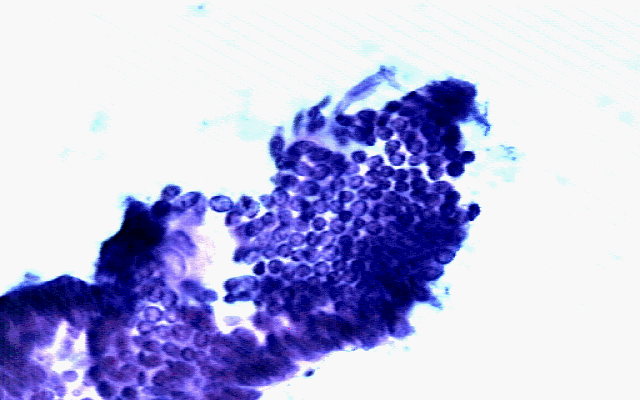

In [5]:
images[92751]

#### Import Data

In [6]:
data = sklearn.datasets.load_breast_cancer()
X = data['data']
Y = data['target']
X_names = data['feature_names']
Y_names = data['target_names']

In [7]:
X_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

### Defining "Attributes"

Here we create attributes by grouping related features

In [8]:
attribute_names = ['radius', 'texture', 'perimeter',
                   'area','smoothness', 'compactness',
                   'concavity', 'concave points', 'symmetry',
                   'fractal dimension']

attribute_idxs = [[idx for idx,f in enumerate(X_names) if attr in f] for attr in attribute_names]

#attribute_order = [j for sublist in [[i, i+10, i+20] for i in range(10)] for j in sublist]



# reorder features by attribute
#X = X[:,attribute_order]
#X_names = X_names[attribute_order]
#attributes = np.split(np.arange(30), 10)

for i,idxs in enumerate(attribute_idxs):
    print('Attrib {} ({}):\t{}'.format(i, attribute_names[i], '\t'.join(X_names[idxs])))    

Attrib 0 (radius):	mean radius	radius error	worst radius
Attrib 1 (texture):	mean texture	texture error	worst texture
Attrib 2 (perimeter):	mean perimeter	perimeter error	worst perimeter
Attrib 3 (area):	mean area	area error	worst area
Attrib 4 (smoothness):	mean smoothness	smoothness error	worst smoothness
Attrib 5 (compactness):	mean compactness	compactness error	worst compactness
Attrib 6 (concavity):	mean concavity	concavity error	worst concavity
Attrib 7 (concave points):	mean concave points	concave points error	worst concave points
Attrib 8 (symmetry):	mean symmetry	symmetry error	worst symmetry
Attrib 9 (fractal dimension):	mean fractal dimension	fractal dimension error	worst fractal dimension


# Model Training

#### Prepare Data

In [9]:
# Data Split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, ids_train, ids_test = \
        train_test_split(X, Y, ids, test_size = 0.25, random_state = 0)

#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Train a Gaussian Naive Bayes Model

In [10]:
import sklearn.naive_bayes

classifier = sklearn.naive_bayes.GaussianNB()
classifier.fit(X_train, Y_train)
print('Accuracy on test: {:4.2f}'.format(100*classifier.score(X_test, Y_test)))


Accuracy on test: 91.61


# Compare Interpretability Methods

In [11]:
import interpret

Let's pick an example to explain. We can pick from missclassified ones:

In [12]:
print(list(np.where(~np.equal(classifier.predict(X_test),Y_test))[0])) # Incorrect predictions

[10, 13, 14, 16, 40, 44, 73, 91, 97, 108, 109, 137]


Interesting ones:
* 108
* 0
* 44
* 91  (nonconfident, incorrect)
* 97  (incorrect, strong positive and negative evidence)
* 137 (incorrect, no significant feature woe, but some sign attrib woes)

Select example id here:

In [13]:
idx = 97

Run classifier on this example:

In [14]:
pred_y = classifier.predict(X_test[idx:idx+1,:])[0]
pred_p = classifier.predict_proba(X_test[idx:idx+1,:])[0,pred_y]
print('True class:      {} ({})'.format(Y_test[idx], Y_names[Y_test[idx]]))
print('Predicted class: {} ({})'.format(pred_y, Y_names[pred_y]))
print('Predicted proba: {:2.4f}'.format(pred_p))

True class:      1 (benign)
Predicted class: 0 (malignant)
Predicted proba: 0.8585


## LIME

In [17]:

# ### Via Interpret ML:
# from interpret.blackbox import LimeTabular
# #Blackbox explainers need a predict function, and optionally a dataset
# lime = LimeTabular(predict_fn=classifier.predict_proba, data=X_train, random_state=1, feature_names=list(X_names))

# #Pick the instances to explain, optionally pass in labels if you have them
# lime_local = lime.explain_local(X_test[idx:idx+5], Y_test[idx:idx+5], name='LIME')#,

# interpret.show(lime_local)


### Or directly via author's code:

import lime.lime_tabular
limeexplainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_names,
                                                       class_names=Y_names, discretize_continuous=True)
exp = limeexplainer.explain_instance(X_test[idx], classifier.predict_proba, num_features=15, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)


## SHAP

In [18]:
### Via Interpret ML:

# from interpret.blackbox import ShapKernel

# background_val = np.median(X_train, axis=0).reshape(1, -1)
# shap = ShapKernel(predict_fn=classifier.predict_proba, data=background_val, feature_names=X_names)
# shap_local = shap.explain_local(X_test[idx:idx+5], Y_test[idx:idx+5], name='SHAP')
# interpret.show(shap_local)

### Or directly from the authors' code:
import shap 
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer   = shap.KernelExplainer(classifier.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test[idx,:], nsamples=100)

# Use the ones for predicted class?
shap_values = shap_values[classifier.predict(X_test[idx:idx+1,:])[0]]

# plot the SHAP values
shap.force_plot(explainer.expected_value[0], shap_values, X_test[idx,:], link="logit")

Using 426 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


## GAM

In [23]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier(n_jobs=1)
ebm.fit(X_train, Y_train)

from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7044/4836261648/ -->

## WOE

In [24]:
import src.woe_new
import src.utils
importlib.reload(src.woe_new)
importlib.reload(src.utils)
import src.explainers
importlib.reload(src.explainers)
from src.explainers import WOE_Explainer
from src.woe_new import woe_scikit_gnb

Example index: 0
Prediction: malignant (p=0.86)
True class: benign
Bayes odds explanation:

       1.80     =           -0.52  +  2.32    
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of "malignant":     2.32
woe(         compactness) =    11.34
woe(           concavity) =     7.99
woe(   fractal dimension) =     2.00
woe(      concave points) =     1.26
woe(          smoothness) =    -0.89
woe(            symmetry) =    -1.54
woe(             texture) =    -3.38
woe(           perimeter) =    -3.43
woe(              radius) =    -4.95
woe(                area) =    -6.07
                      sum =     2.32



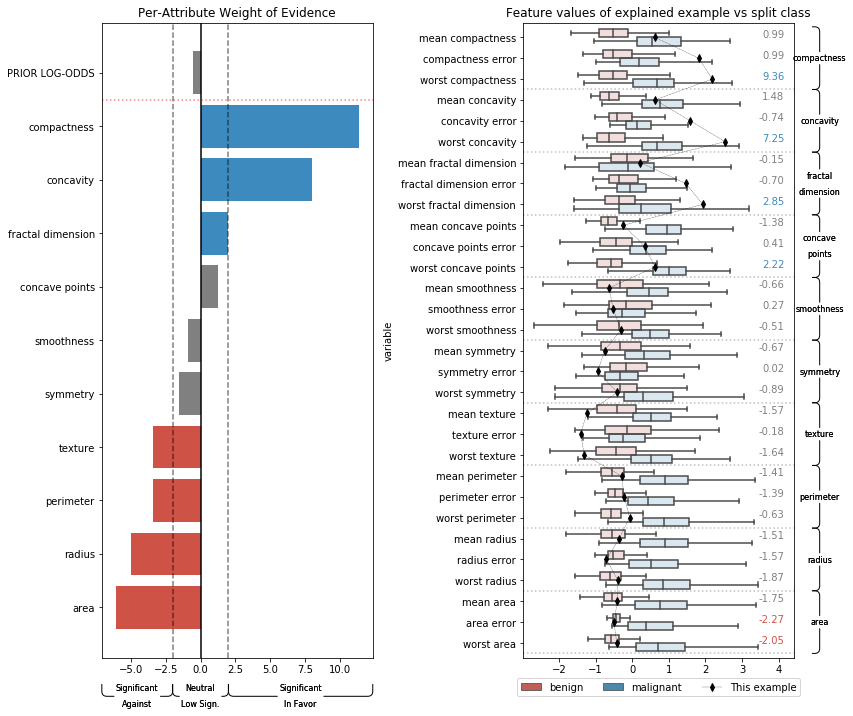

In [25]:
# Create a WoE model for the classifier
woe_model = woe_scikit_gnb(classifier, classes = [0,1])    

# Instantiate woe-based explainer
explainer = WOE_Explainer(classifier, woe_model,
                          classes=Y_names, features=X_names,
                          X=X_train, Y=Y_train,
                          attribute_idxs = attribute_idxs,
                          attribute_names = attribute_names)

# Explain the example
e = explainer.explain(X_test[idx:idx+5], Y_test[idx:idx+5])


We can also explain directly in terms of features instead of attributes:

Example index: 0
Prediction: malignant (p=0.86)
True class: benign
Bayes odds explanation:

       1.80     =           -0.52  +  2.32    
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of "malignant":     2.32
woe(   worst compactness) =     9.36
woe(     worst concavity) =     7.25
woe(worst fractal dimension) =     2.85
woe(worst concave points) =     2.22
woe(      mean concavity) =     1.48
woe(   compactness error) =     0.99
woe(    mean compactness) =     0.99
woe(concave points error) =     0.41
woe(    smoothness error) =     0.27
woe(      symmetry error) =     0.02
woe(mean fractal dimension) =    -0.15
woe(       texture error) =    -0.18
woe(    worst smoothness) =    -0.51
woe(     worst perimeter) =    -0.63
woe(     mean smoothness) =    -0.66
woe(       mean symmetry) =    -0.67
woe(fractal dimension error) =    -0.70
woe(     concavity error) =    -0.74
woe(      worst symmetry) =    -0.89
woe( mean concave points) =    -1.38
woe(     perimeter e

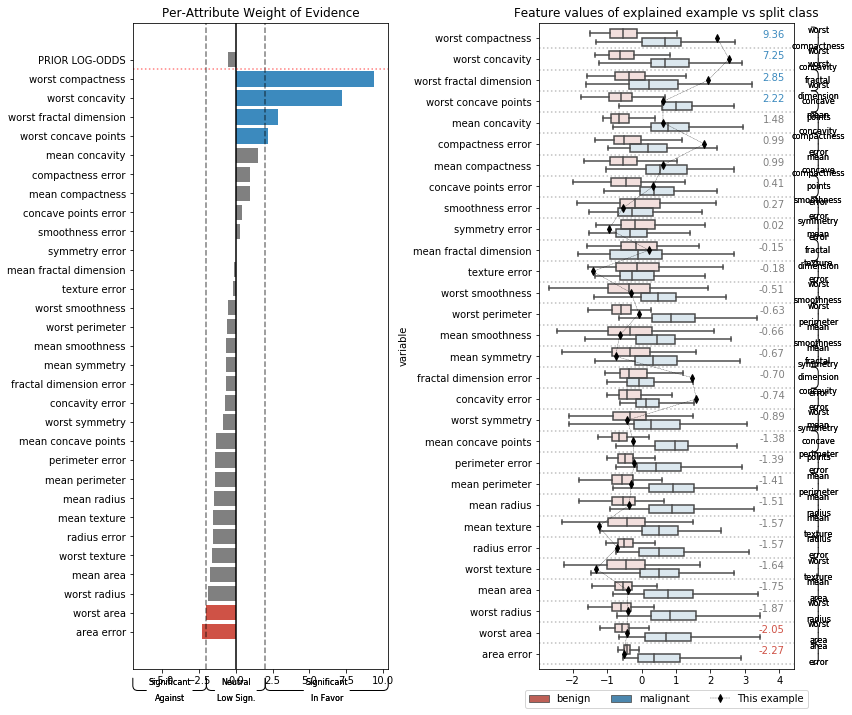

In [26]:
feature_idxs = [[i] for i in range(30)]

explainer = WOE_Explainer(classifier, woe_model,
                          classes=Y_names, features=X_names,
                          X=X_train, Y=Y_train,
                          attribute_idxs = feature_idxs, attribute_names = X_names)

e = explainer.explain(X_test[idx:idx+5], Y_test[idx:idx+5])


# Counterfactual Interventions

Visualizing subtle single-feature interventions that lead to drastic changes in prediction

In [30]:
from src.interventions import find_best_intervention


x, y = X_test[idx,:], Y_test[idx]

x_hat, feat, d = find_best_intervention(classifier, x, X_train, Y_train, 'class_median')

pred_class = classifier.predict(x[None,:])[0]
print("\nIntervened Feat: '{}'.".format(X_names[feat]))
print("Change in Value: {:2.2f} -> {:2.2f}.".format(x[feat], x_hat[feat]))
print("Effect in Pred : p('{}') {:2.3f} -> {:2.3f}.\n".format(Y_names[pred_class],
                                                      classifier.predict_proba(x[None,:])[0,pred_class],
                                                      classifier.predict_proba(x_hat[None,:])[0,pred_class]                                                          
                                                      ))


Intervened Feat: 'worst compactness'.
Change in Value: 2.19 -> -0.53.
Effect in Pred : p('malignant') 0.858 -> 0.000.



Example index: 0



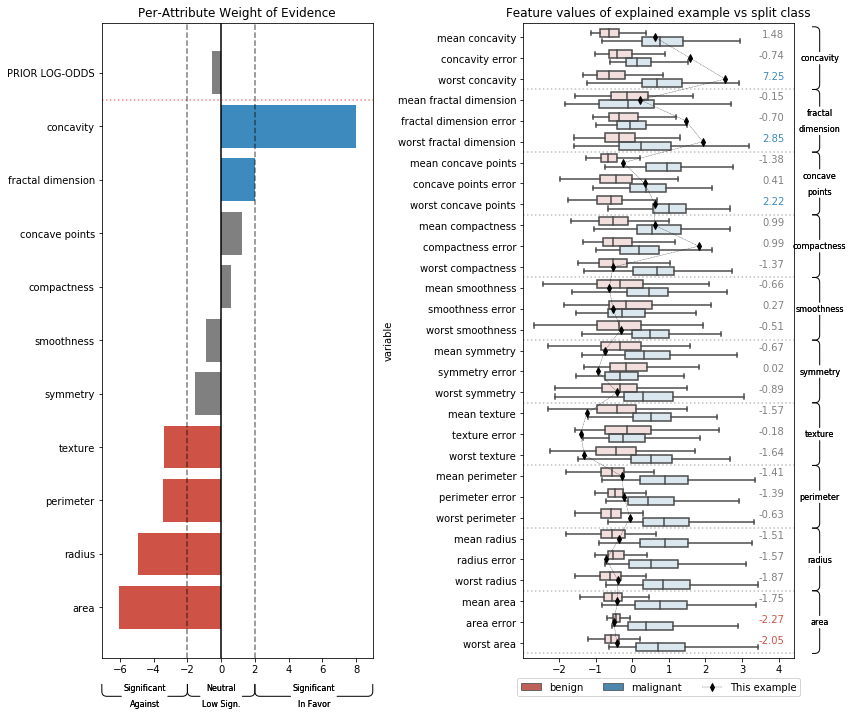

In [31]:

# Instantiate woe-based explainer
explainer = WOE_Explainer(classifier, woe_model,
                          classes=Y_names, features=X_names,
                          X=X_train, Y=Y_train,
                          attribute_idxs = attribute_idxs,
                          attribute_names = attribute_names)

# Explain again, now using counterfactual example:
e = explainer.explain(x_hat[None,:],  Y_test[idx:idx+1], totext=False)


# TRASHES - IGNORE

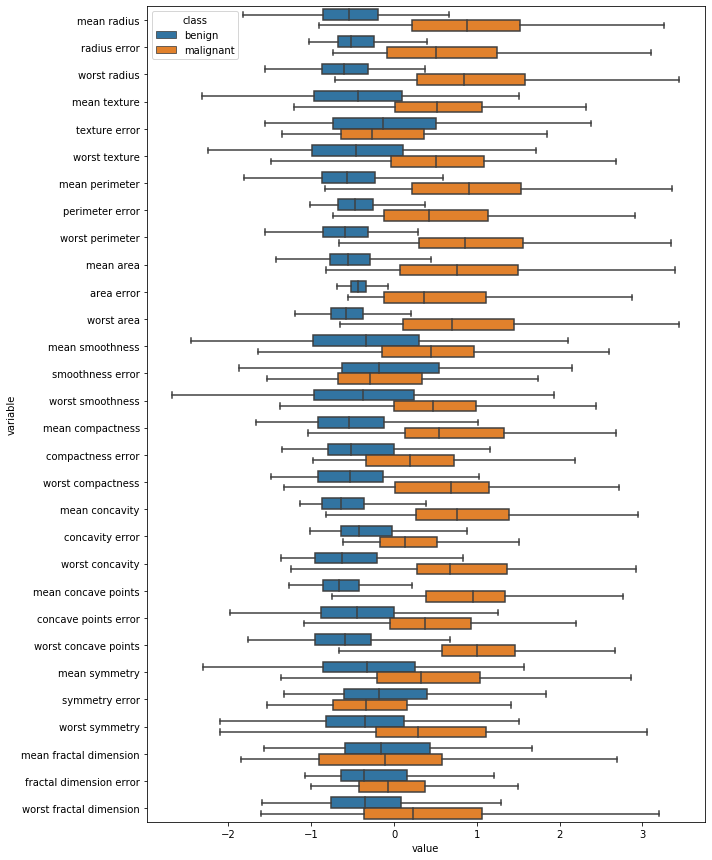

In [372]:
idx = 51
fig, ax = plt.subplots(figsize=(10,15))
df = pd.DataFrame(np.hstack([X_train, Y_train[:,None].astype(int)]), columns = list(X_names) + ['class'])
classes = explainer.classes
melted = df.melt(id_vars= ['class'])
melted = melted.replace({"class": dict(zip(range(len(classes)), list(classes)))})
#ax = sns.boxplot(data=melted, orient="h", y = 'variable')#, hue='class', palette="Set2", ax = ax)
sns.boxplot(data=melted, y='variable', x='value', hue = 'class', orient = 'h', showfliers = False)


In [533]:
print(e)

Prediction: benign (p=1.00)
True class: malignant
Bayes odds explanation:

     -14.21     =           -0.52  +  -13.69  
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of "malignant":   -13.69
woe(             texture) =     1.26
woe(              radius) =     1.11
woe(                area) =     0.87
woe(           perimeter) =     0.42
woe(   fractal dimension) =    -0.80
woe(            symmetry) =    -1.42
woe(          smoothness) =    -2.50
woe(           concavity) =    -2.90
woe(         compactness) =    -3.58
woe(      concave points) =    -6.15
                      sum =   -13.69



In [42]:
means_mal = X_test[Y_test == 0].mean(axis=0) # Malignant
means_ben = X_test[Y_test == 1].mean(axis=0) # Malignant

idxs = np.array(attribute_idxs)[np.array(attribute_names) == 'concave points']
print(X_names[idxs])
print(means_ben[idxs])
print(means_mal[idxs])

X_test[idx, idxs]

[['mean concave points' 'concave points error' 'worst concave points']]
[[-0.62090591 -0.38160109 -0.65033873]]
[[0.99209172 0.81997389 0.99409002]]


array([[0.84017194, 0.27743345, 1.37043754]])

In [366]:
dict(zip(range(len(classes)), list(classes)))

{0: 'malignant', 1: 'benign'}

In [364]:
classes

array(['malignant', 'benign'], dtype='<U9')

In [429]:


print(woe_model.woe(X_test[:3,:], 1, 0, verbose = True))



H is simple hypotesis
H is simple hypotesis
[-23.88068615  31.21006105  33.59700322]
